In [8]:
%pip install chess

Note: you may need to restart the kernel to use updated packages.


In [9]:
import random

import chess
from IPython import display
import numpy as np
import torch

from src.data.dataset import encode_position
from src.data.vocab import build_vocab

In [10]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)

In [11]:
model = torch.load('models/position_transformer/best.ckpt', map_location='cpu')
vocab = build_vocab()

In [15]:
def generate_game(model: torch.nn.Module):
    generated_moves = []
    generated_positions = []
    board = chess.Board()
    terminals = {'1-0', '0-1', '1/2-1/2'}
    while not board.is_game_over():
        encoded_position = encode_position(board)
        generated_positions.append(encoded_position)
        inputs = torch.tensor(np.array(generated_positions))
        inputs = inputs.view(1, *inputs.shape)
        outputs = model(inputs)
        move_logits = outputs[0, -1]
        legal_moves_indicies = vocab([move.uci() for move in board.legal_moves])
        mask = torch.zeros_like(move_logits) - torch.inf
        mask[legal_moves_indicies] = 0
        move_logits += mask
        move_probs = torch.softmax(move_logits, dim=0)
        move_probs = move_probs ** 2
        move_probs /= move_probs.sum()
        move_index = torch.multinomial(move_probs, 1)
        move = vocab.lookup_token(move_index)
        if move in terminals:
            break
        board.push_uci(move)
        generated_moves.append(move)
    return generated_moves

In [16]:
def show_game(moves: list[str]):
    board = chess.Board()
    for move in moves:
        display.display(board)
        board.push_uci(move)
    display.display(board)

In [17]:
game = generate_game(model)

TypeError: multinomial() missing 1 required positional arguments: "num_samples"

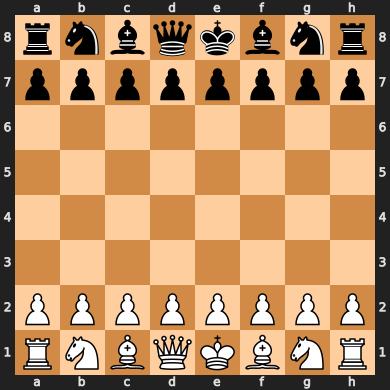

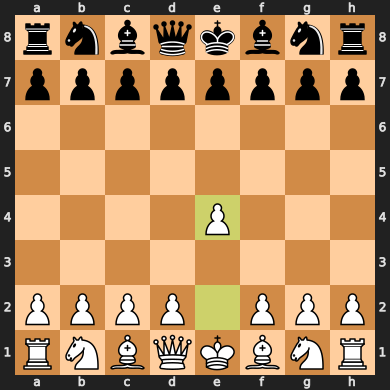

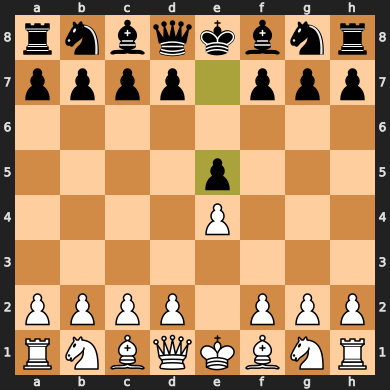

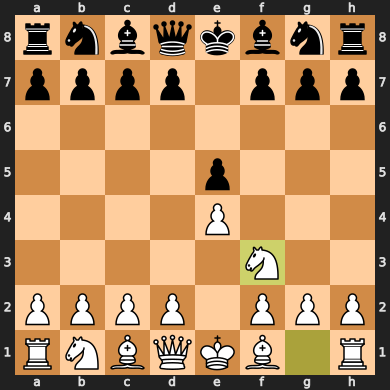

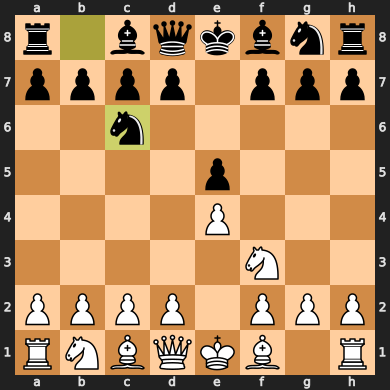

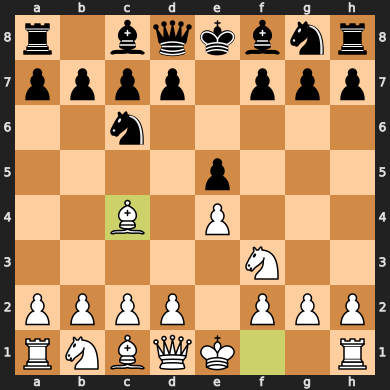

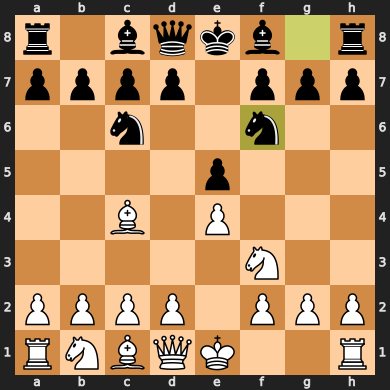

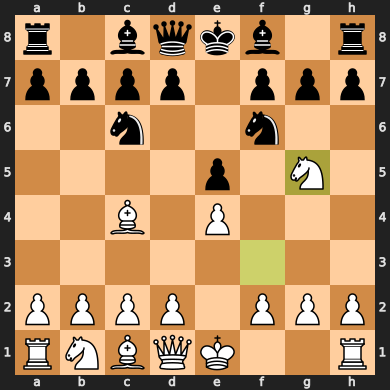

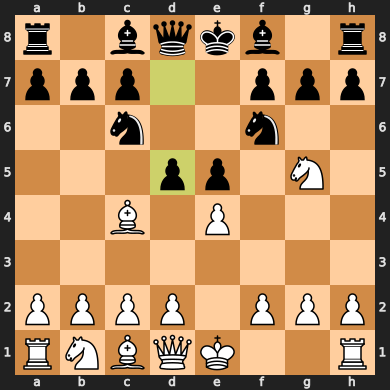

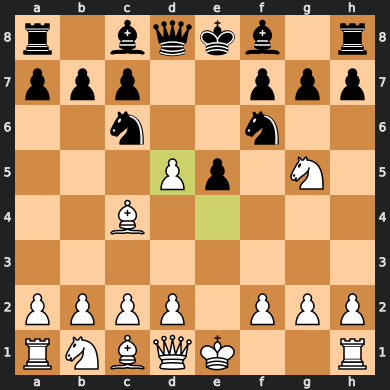

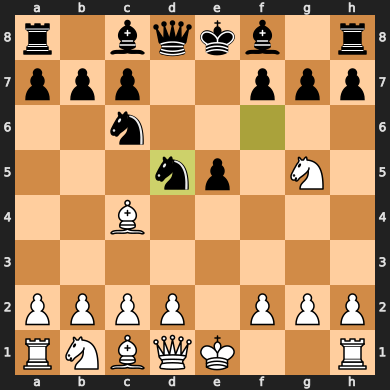

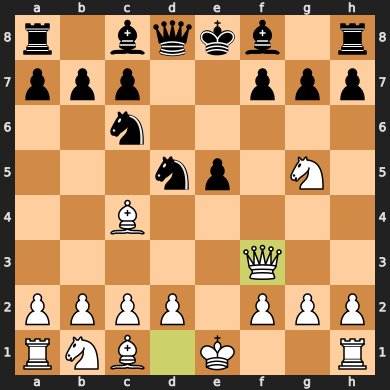

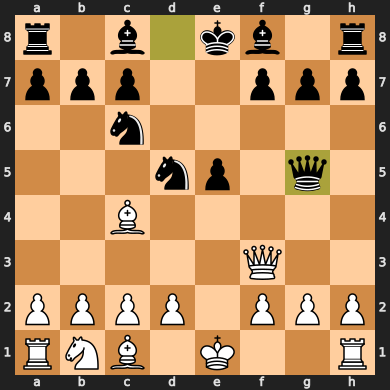

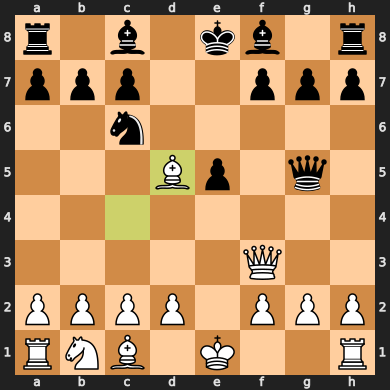

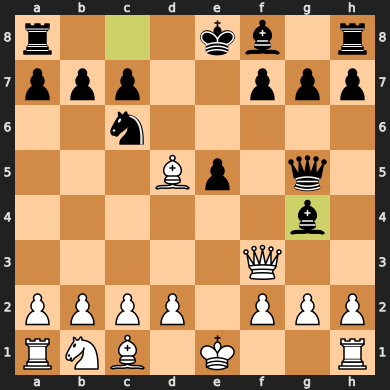

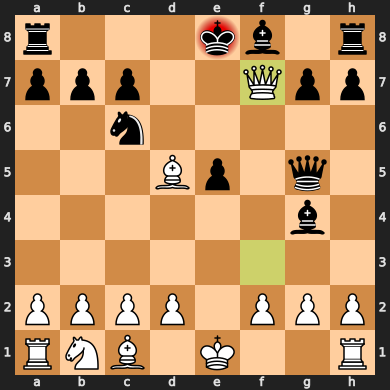

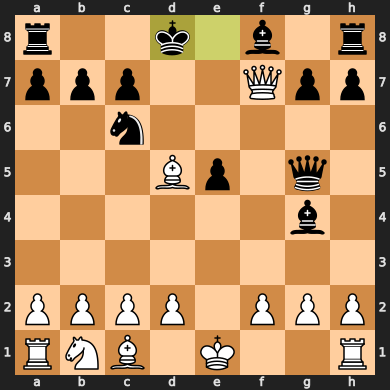

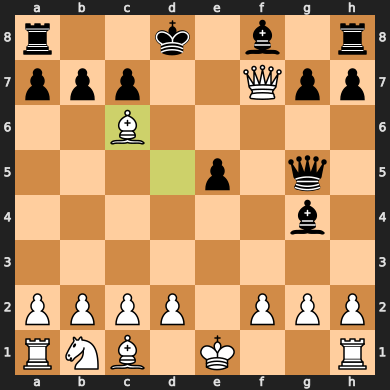

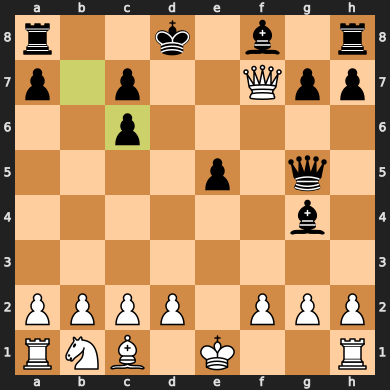

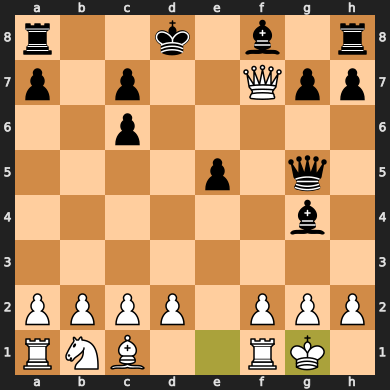

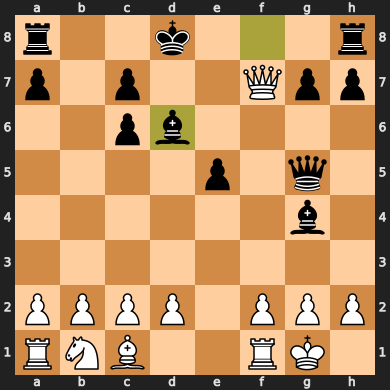

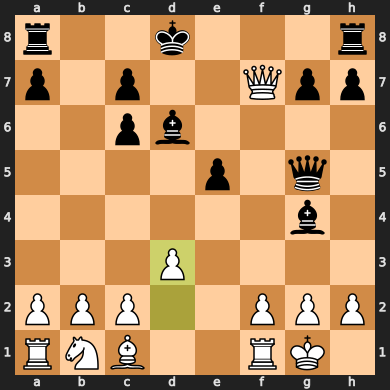

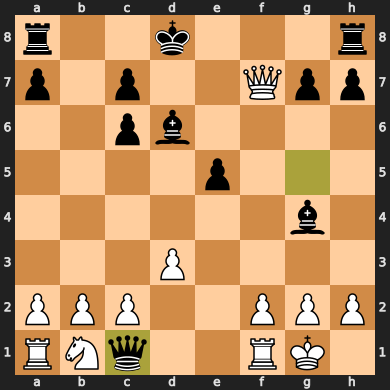

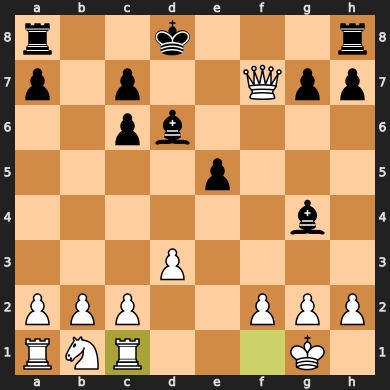

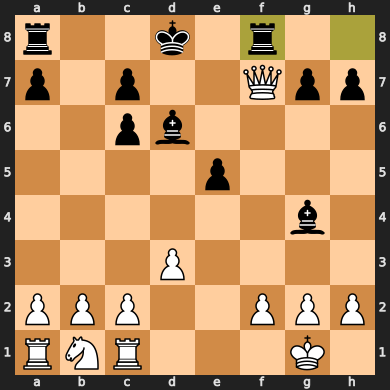

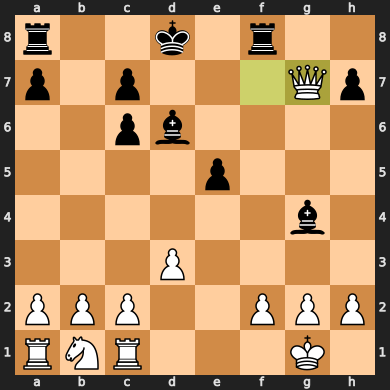

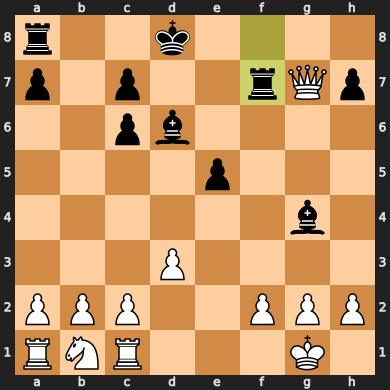

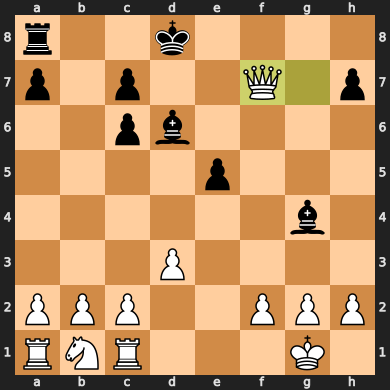

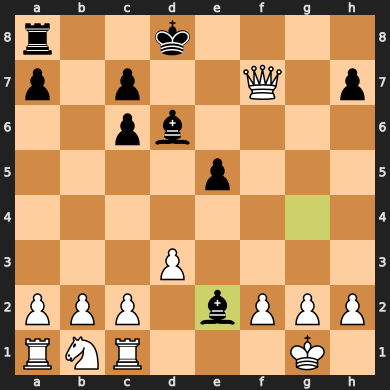

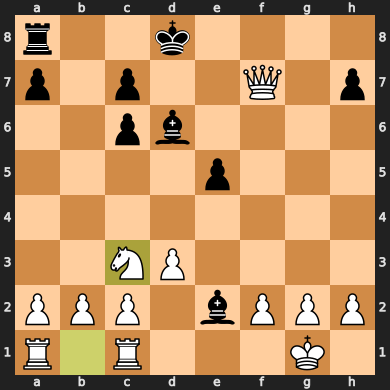

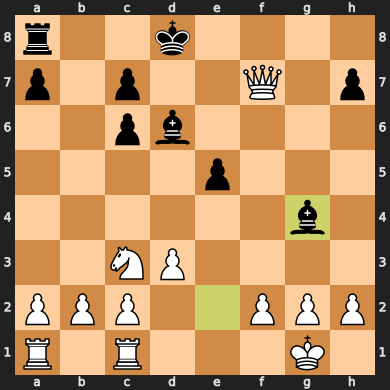

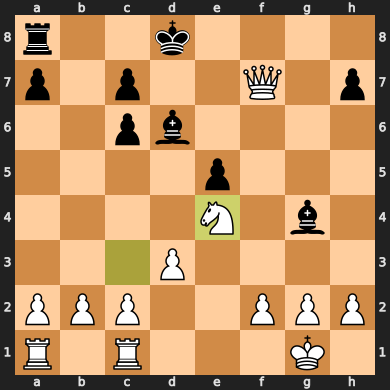

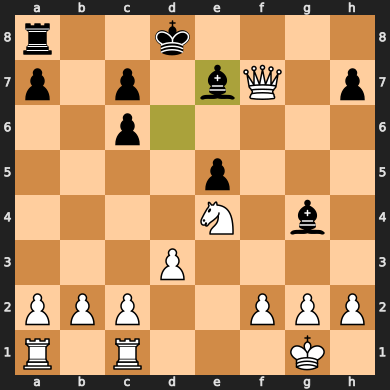

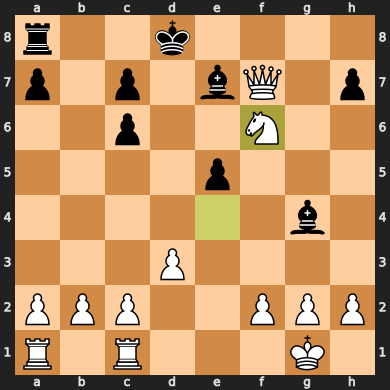

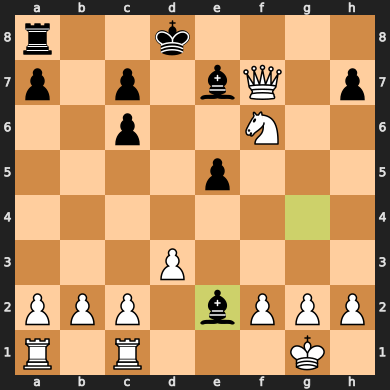

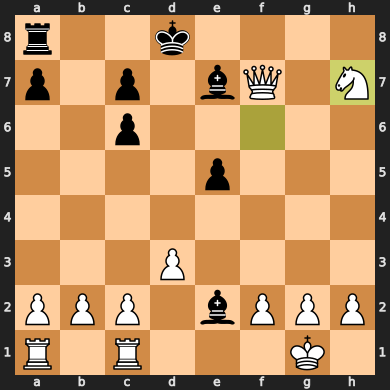

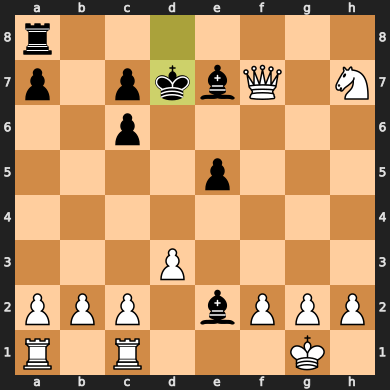

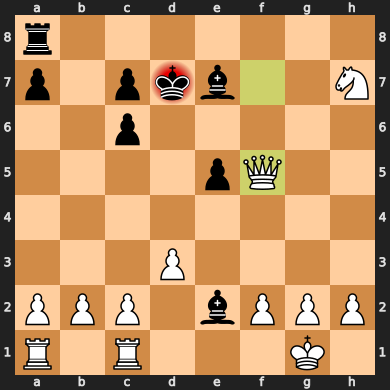

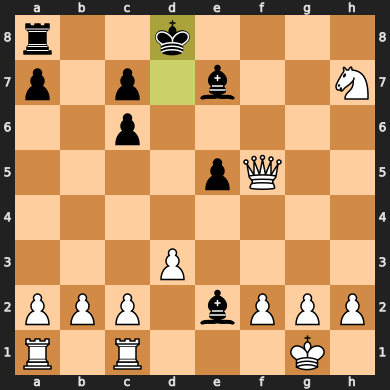

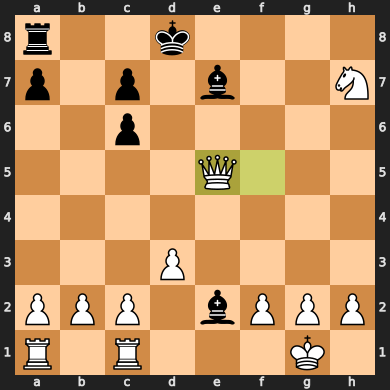

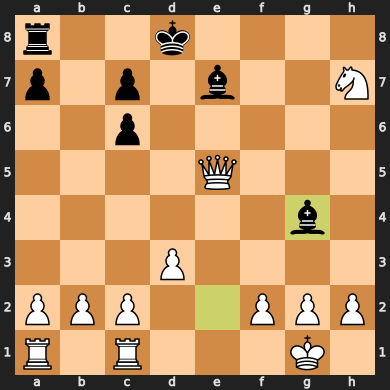

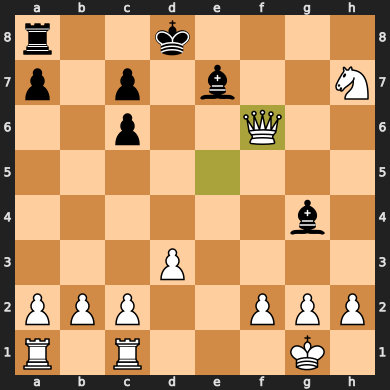

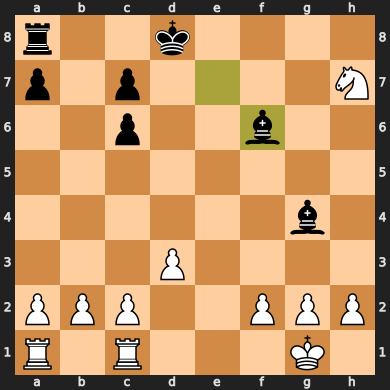

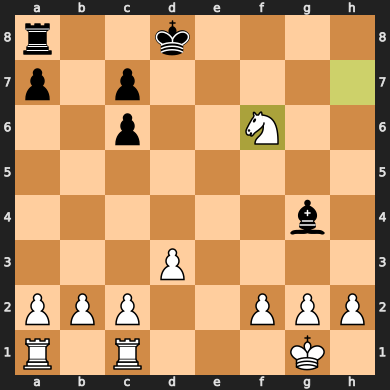

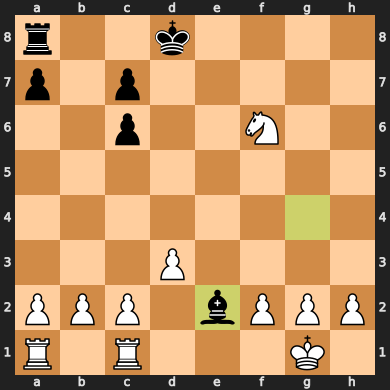

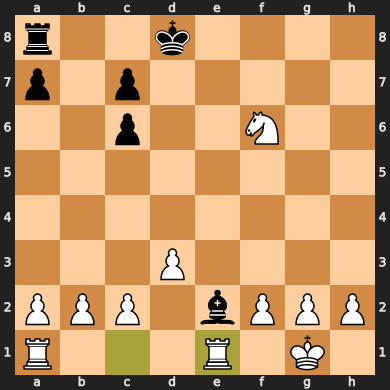

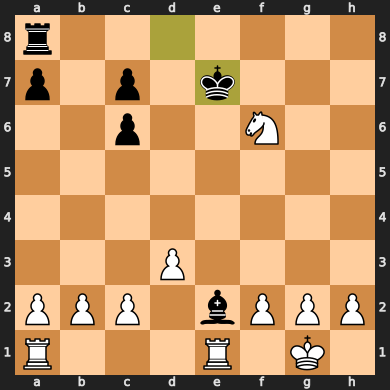

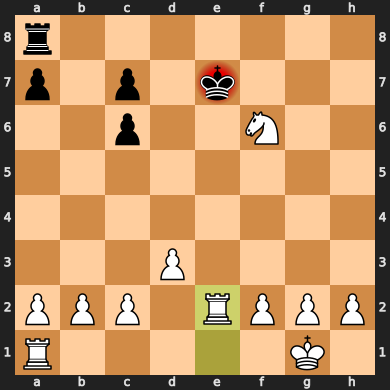

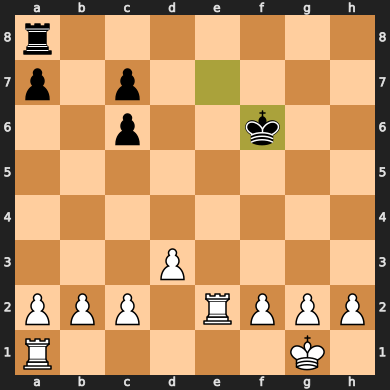

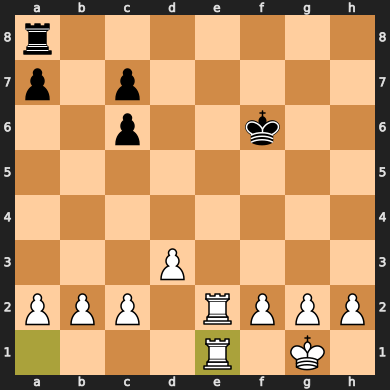

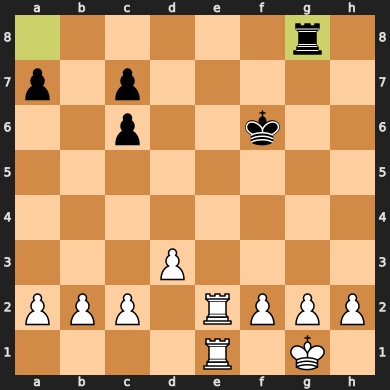

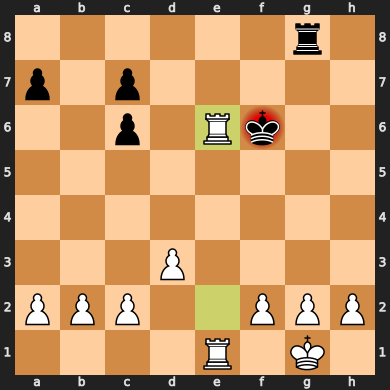

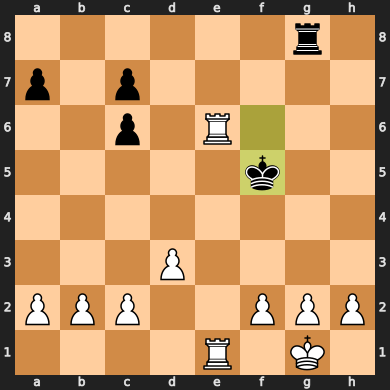

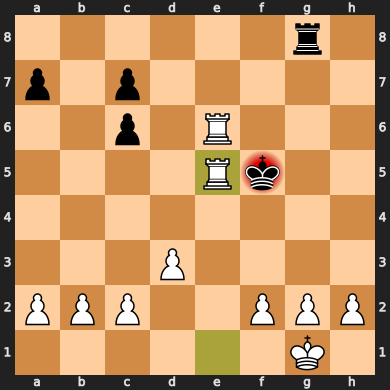

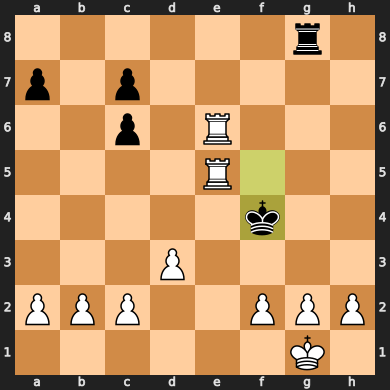

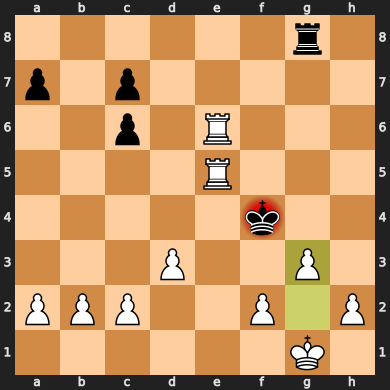

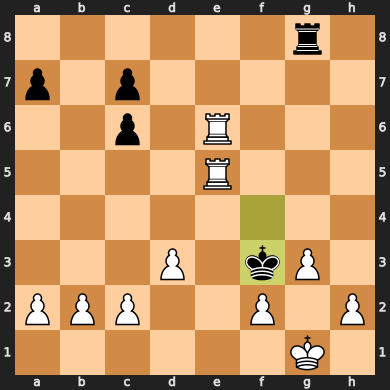

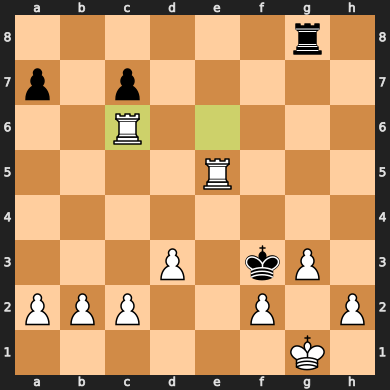

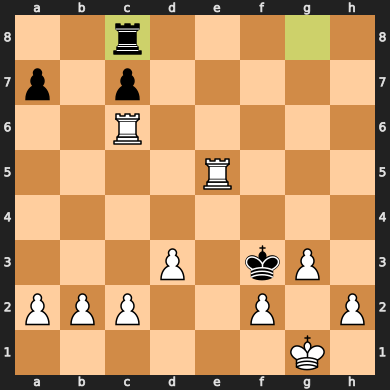

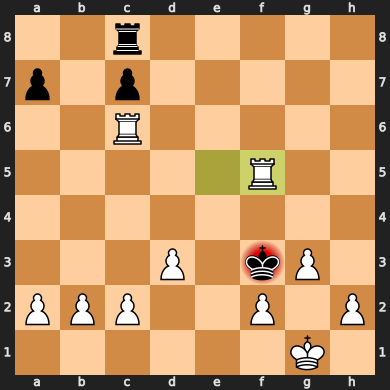

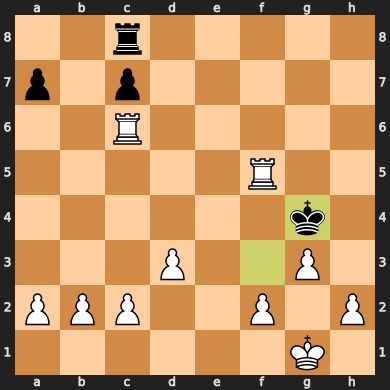

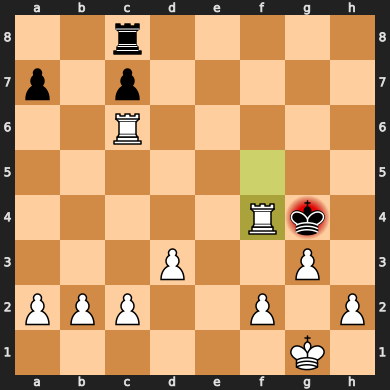

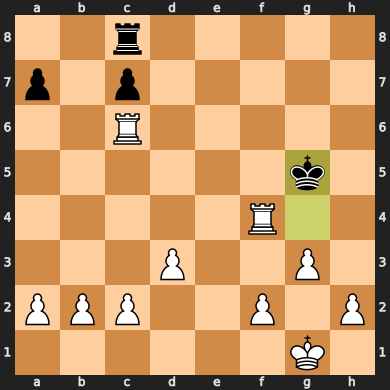

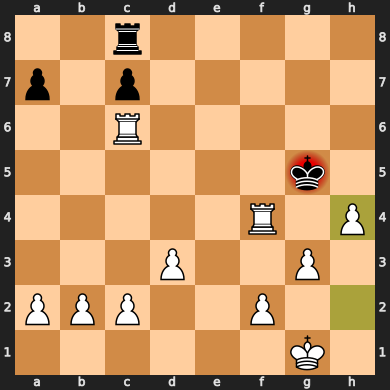

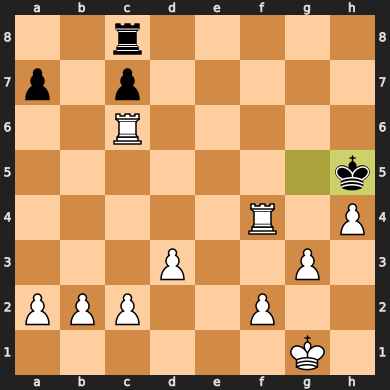

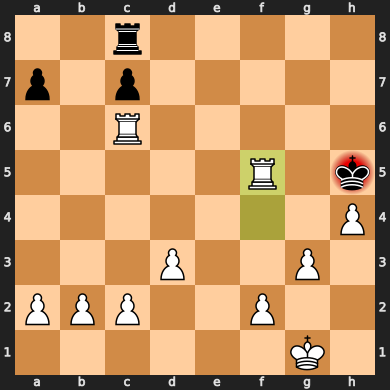

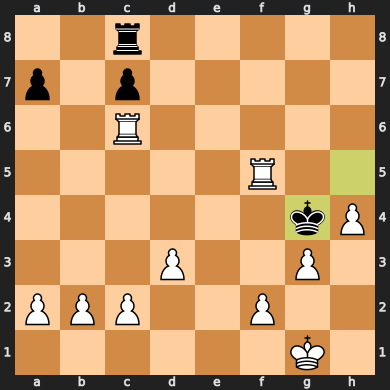

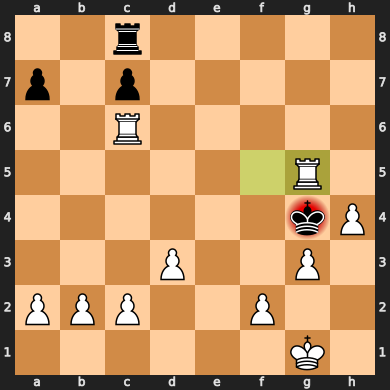

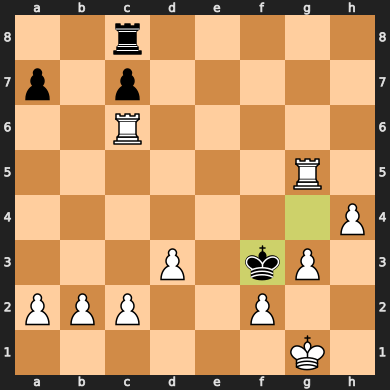

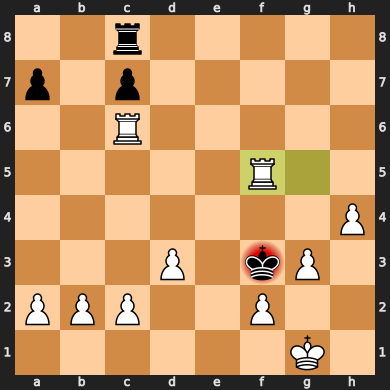

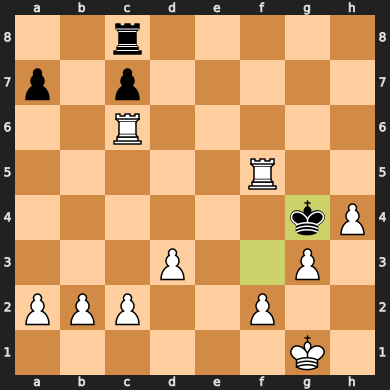

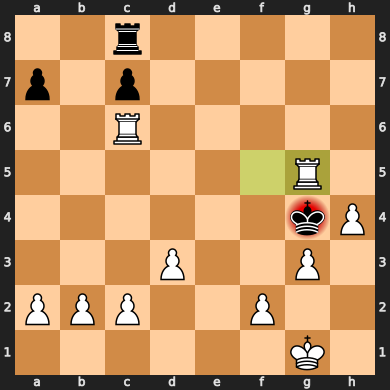

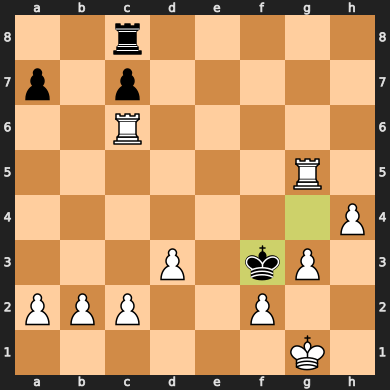

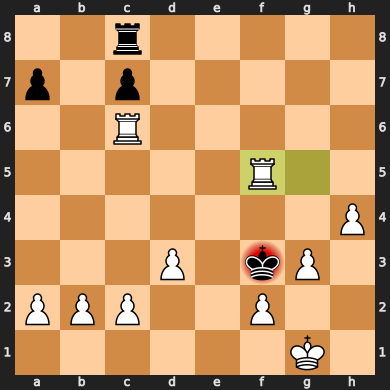

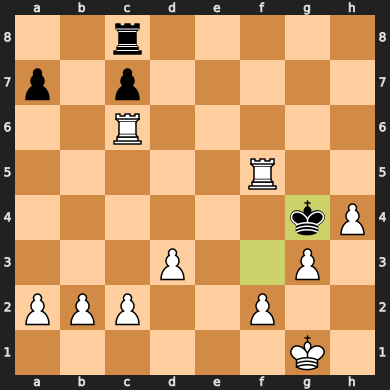

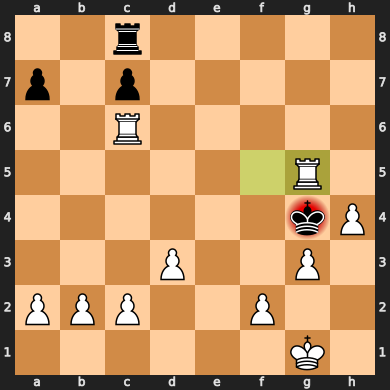

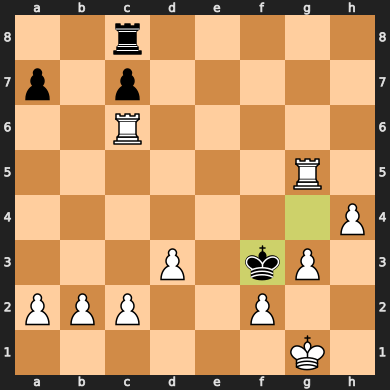

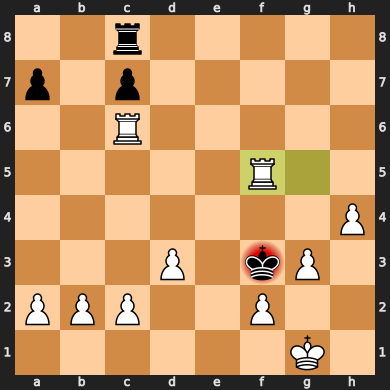

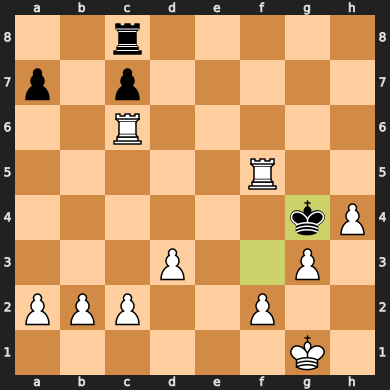

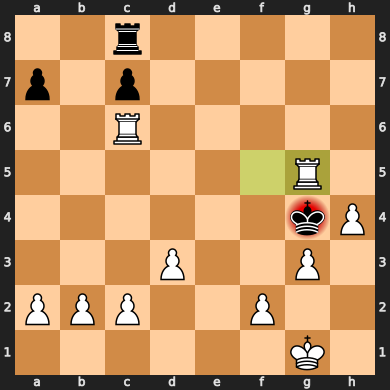

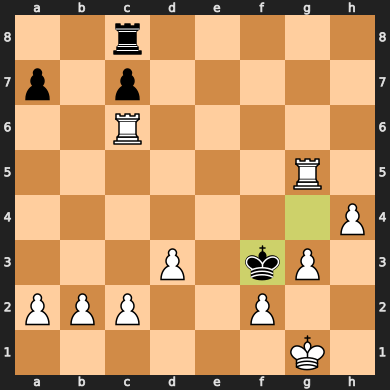

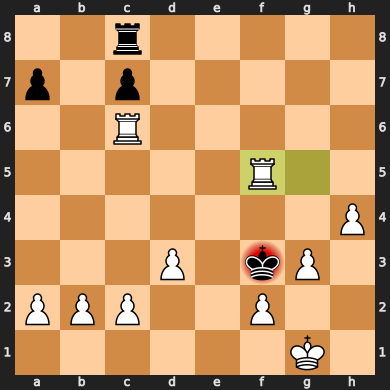

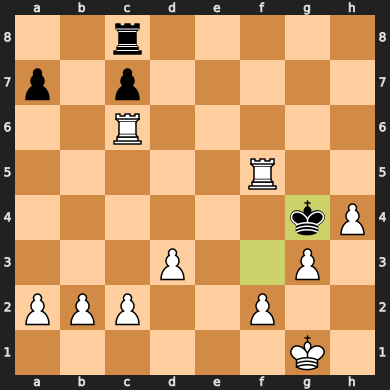

In [ ]:
show_game(game)